In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import nltk
import os


In [39]:
df_news = pd.read_csv("../data/raw_analyst_ratings.csv")

In [40]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [41]:



df_news['date'] = pd.to_datetime(df_news['date'], errors='coerce')
df_news = df_news.dropna(subset=['date'])  

df_news['headline_length'] = df_news['headline'].astype(str).apply(len)

df_news['sentiment'] = df_news['headline'].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)


Step 2: Plot and EDA Visuals

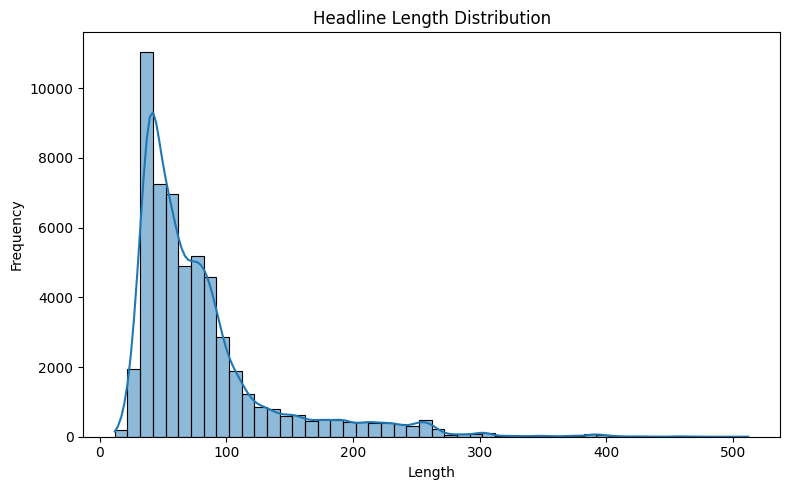

In [42]:
# 1. Headline Length Distribution
plt.figure(figsize=(8,5))
sns.histplot(df_news['headline_length'], bins=50, kde=True)
plt.title("Headline Length Distribution")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("../images/headline_length_hist.png")
plt.show()

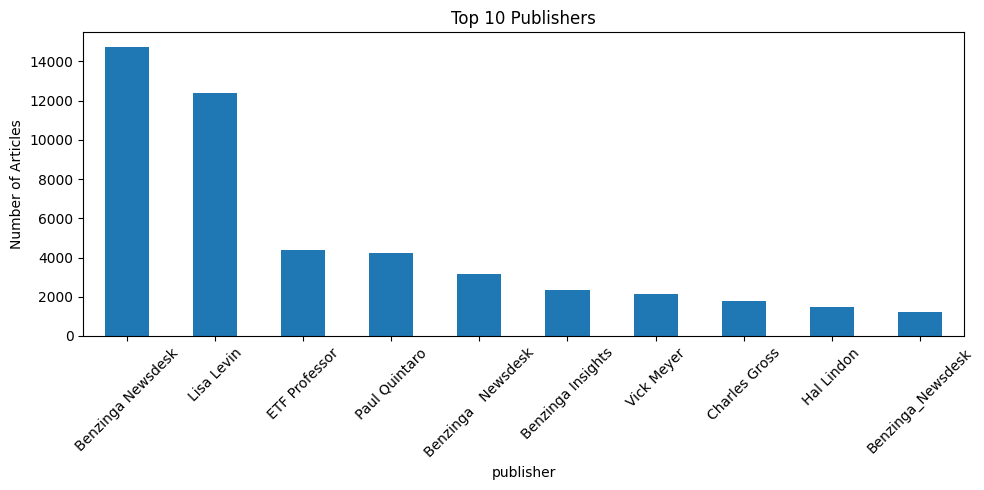

In [43]:
# 2. Top 10 Publishers
plt.figure(figsize=(10,5))
df_news['publisher'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 Publishers")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../images/top_publishers_bar.png")
plt.show()

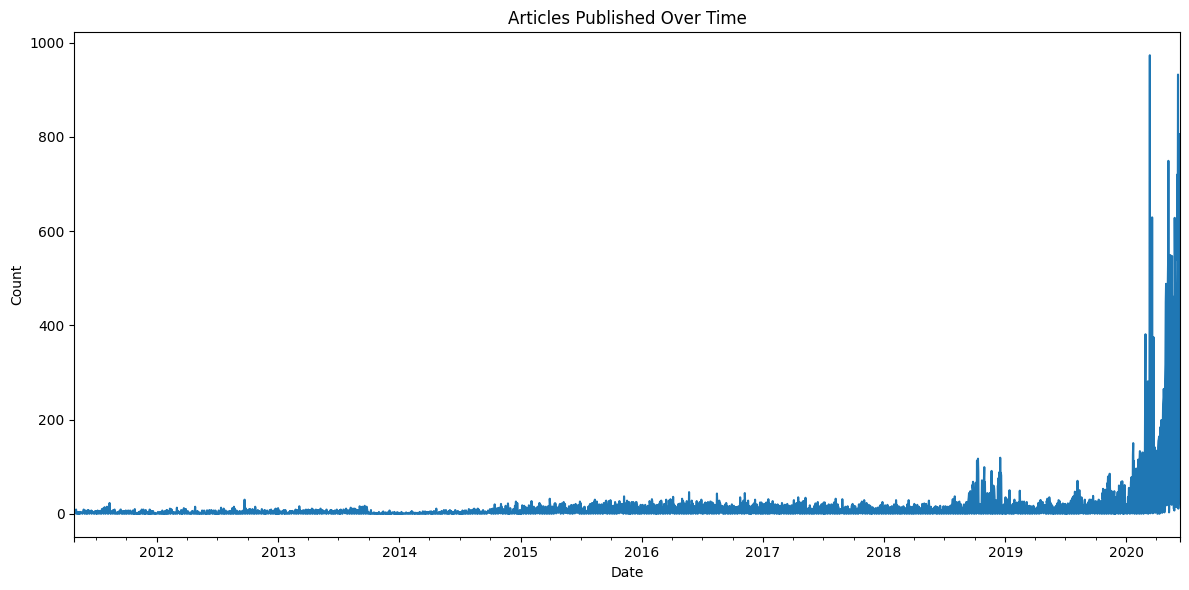

In [44]:
# 3. Articles Published Per Day
articles_per_day = df_news.set_index('date').resample('D').size()
plt.figure(figsize=(12,6))
articles_per_day.plot()
plt.title("Articles Published Over Time")
plt.ylabel("Count")
plt.xlabel("Date")
plt.tight_layout()
plt.savefig("../images/articles_over_time_line.png")
plt.show()

In [45]:
# Most Positive Headlines
print("Most Positive Headlines:")
print(df_news[['headline', 'sentiment']].sort_values(by='sentiment', ascending=False).head(5))

# Most Negative Headlines
print("\nMost Negative Headlines:")
print(df_news[['headline', 'sentiment']].sort_values(by='sentiment', ascending=True).head(5))


Most Positive Headlines:
                                                  headline  sentiment
1204942                                5 Best ETFs Of 2019        1.0
339614          Pound Punishment Is Perfect For These ETFs        1.0
145743   The Street Debates Whether Best Buy Investors ...        1.0
1149384                                5 Best ETFs Of 2019        1.0
688090   Jefferies Highlights 5 Best Investment Ideas F...        1.0

Most Negative Headlines:
                                                  headline  sentiment
83634    Mizuho Upgrades Occidental Petroleum, Says Wor...       -1.0
701728   ETFs To Play/Avoid On The Shocking Steve Jobs ...       -1.0
700464   This Hedge Fund Manager's Worst Ideas For 2016...       -1.0
1115337       Worst Performing Industries For June 4, 2015       -1.0
1115333       Worst Performing Industries For July 8, 2015       -1.0


task 2

In [46]:
import glob
import talib

Load All Stock  Files

In [77]:
file_paths = glob.glob("../data/*_historical_data.csv")
stock_data = []


Prepare Each Stock data

In [80]:


for file_path in file_paths:
    ticker = os.path.splitext(os.path.basename(file_path))[0].split("_")[0]  
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['date'])
    df['stock'] = ticker
    stock_data.append(df[['date', 'Open', 'High', 'Low', 'Close', 'Volume', 'stock']])

df_all_tech = pd.concat(stock_data)

for AAPL

In [81]:
df_aapl = df_all_tech[df_all_tech['stock'] == 'AAPL'].copy()
df_aapl = df_aapl.sort_values('date')


Calculate Indicators 

In [51]:
df_aapl['SMA_14'] = talib.SMA(df_aapl['Close'], timeperiod=14)
df_aapl['RSI_14'] = talib.RSI(df_aapl['Close'], timeperiod=14)
df_aapl['MACD'], df_aapl['MACD_signal'], df_aapl['MACD_hist'] = talib.MACD(df_aapl['Close'])


Plot AAPL Close Price and SMA

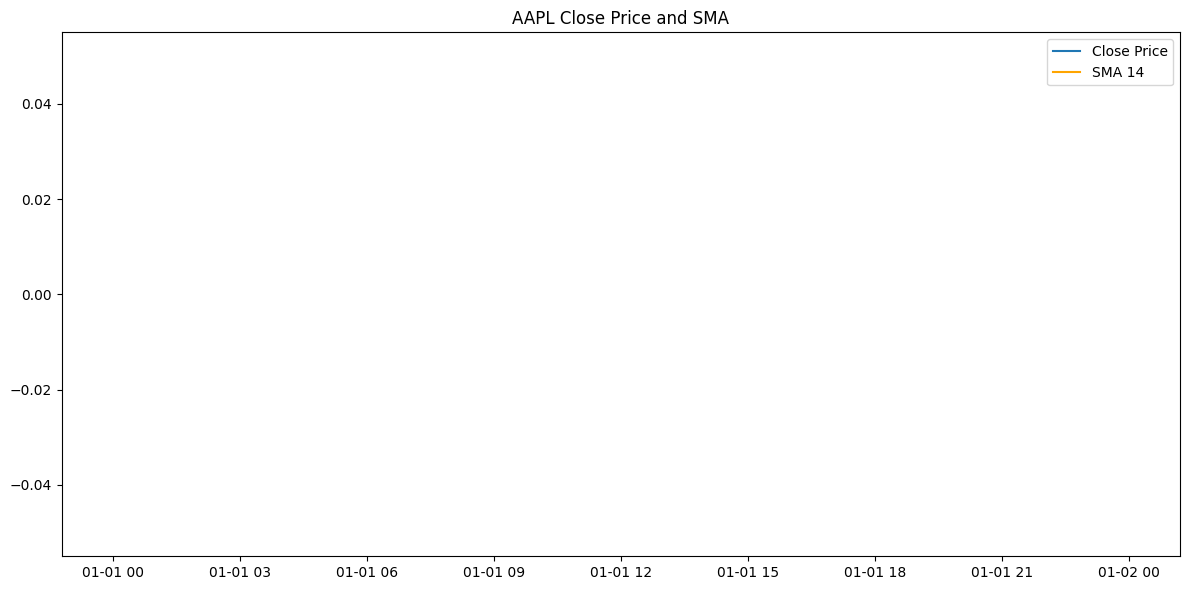

In [52]:
plt.figure(figsize=(12,6))
plt.plot(df_aapl['date'], df_aapl['Close'], label='Close Price')
plt.plot(df_aapl['date'], df_aapl['SMA_14'], label='SMA 14', color='orange')
plt.title("AAPL Close Price and SMA")
plt.legend()
plt.tight_layout()
plt.savefig("../images/aapl_sma_plot.png")
plt.show()


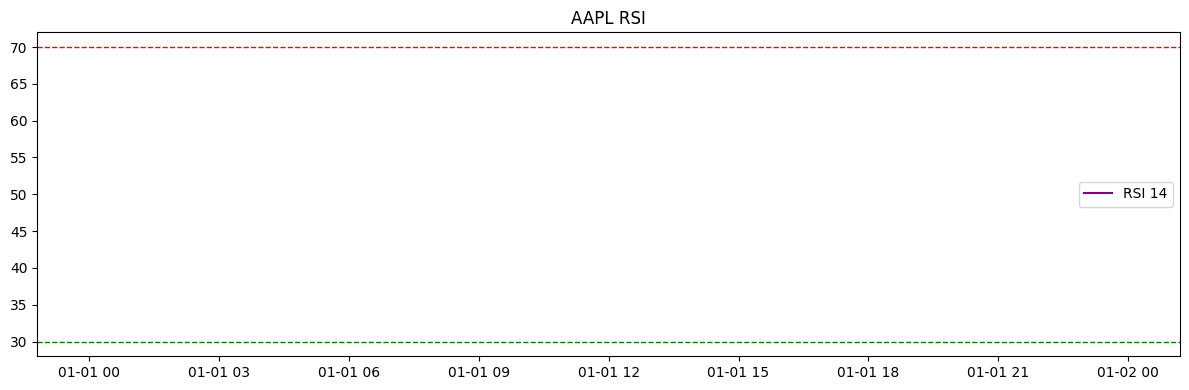

In [53]:
plt.figure(figsize=(12,4))
plt.plot(df_aapl['date'], df_aapl['RSI_14'], label='RSI 14', color='purple')
plt.axhline(70, color='red', linestyle='--', linewidth=1)   
plt.axhline(30, color='green', linestyle='--', linewidth=1) 
plt.title("AAPL RSI")
plt.legend()
plt.tight_layout()
plt.savefig("../images/aapl_rsi_plot.png")
plt.show()


task-3 final submition 

In [82]:
all_tech = []

for stock in df_all_tech['stock'].unique():
    df = df_all_tech[df_all_tech['stock'] == stock].sort_values('date').copy()
    
    df['SMA_14'] = talib.SMA(df['Close'], timeperiod=14)
    df['RSI_14'] = talib.RSI(df['Close'], timeperiod=14)
    df['MACD'], df['MACD_signal'], df['MACD_hist'] = talib.MACD(df['Close'])
    
    all_tech.append(df)

df_all_tech = pd.concat(all_tech)

 Daily Returns for All Stocks

In [84]:
df_all_tech['return'] = df_all_tech.groupby('stock')['Close'].pct_change()
df_all_tech = df_all_tech.dropna(subset=['return'])


Merge with Sentiment Data

In [63]:
# Group by stock and date
daily_sentiment = df_news.groupby(['stock', 'date'])['sentiment'].mean().reset_index()
daily_sentiment.columns = ['stock', 'date', 'avg_sentiment']


In [85]:
# Clean dates again
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date']).dt.tz_localize(None).dt.normalize()
df_all_tech['date'] = pd.to_datetime(df_all_tech['date']).dt.normalize()

# Merge
df_merged = pd.merge(daily_sentiment, df_all_tech, on=['stock', 'date'], how='inner')
print("Merged shape:", df_merged.shape)
print(df_merged.head())


Merged shape: (49, 14)
  stock       date  avg_sentiment       Open       High        Low      Close  \
0  AAPL 2020-06-09       0.053333  83.035004  86.402496  83.002502  85.997498   
1  AAPL 2020-06-09       0.050000  83.035004  86.402496  83.002502  85.997498   
2  AAPL 2020-06-09       0.000000  83.035004  86.402496  83.002502  85.997498   
3  AAPL 2020-06-09       0.250000  83.035004  86.402496  83.002502  85.997498   
4  AAPL 2020-06-10       0.068182  86.974998  88.692497  86.522499  88.209999   

      Volume     SMA_14     RSI_14      MACD  MACD_signal  MACD_hist    return  
0  147712400  80.849643  77.101541  2.649391     2.419143   0.230248  0.031578  
1  147712400  80.849643  77.101541  2.649391     2.419143   0.230248  0.031578  
2  147712400  80.849643  77.101541  2.649391     2.419143   0.230248  0.031578  
3  147712400  80.849643  77.101541  2.649391     2.419143   0.230248  0.031578  
4  166651600  81.449821  80.315077  2.991188     2.533552   0.457636  0.025728  


In [86]:
# Drop duplicate stock-date rows (keep first)
df_merged = df_merged.drop_duplicates(subset=['stock', 'date'])


In [87]:
results = []

for stock, group in df_merged.groupby('stock'):
    group = group.dropna(subset=['avg_sentiment', 'return'])
    if len(group) > 1:
        corr = group['avg_sentiment'].corr(group['return'])
        results.append({'stock': stock, 'correlation': corr})

correlations = pd.DataFrame(results)
print(correlations)


  stock  correlation
0  AAPL    -1.000000
1  AMZN    -1.000000
2  GOOG    -0.271734
3  NVDA    -0.103342


Sentiment vs Return (Scatter Plot)

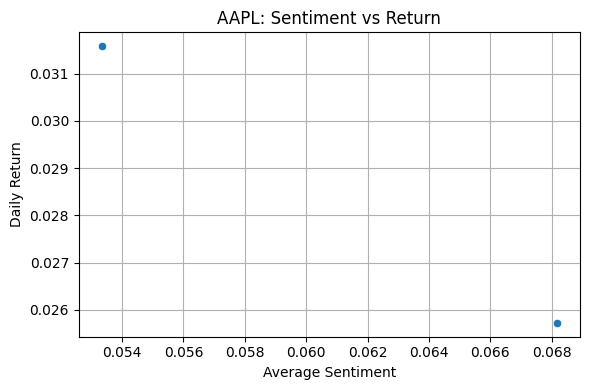

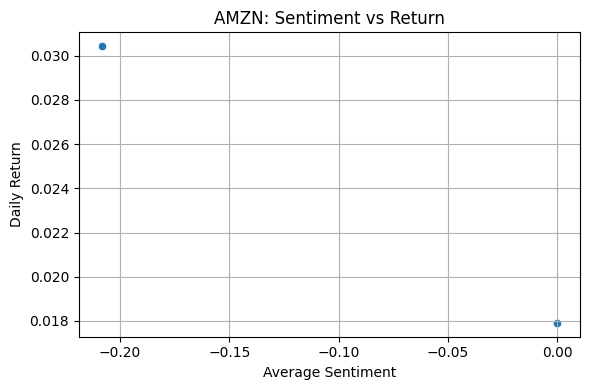

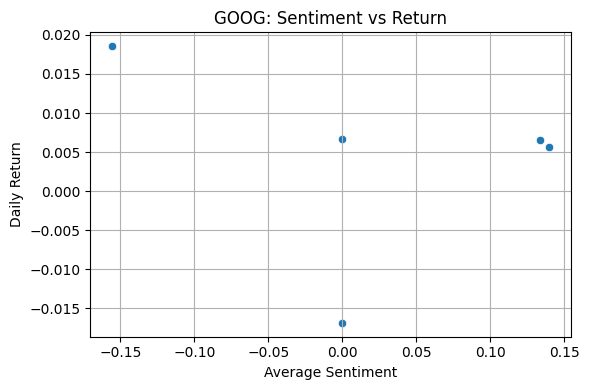

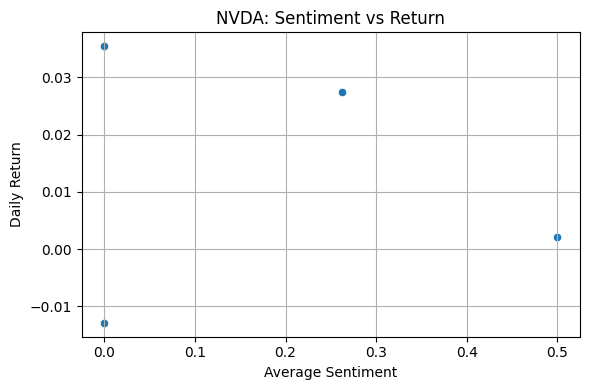

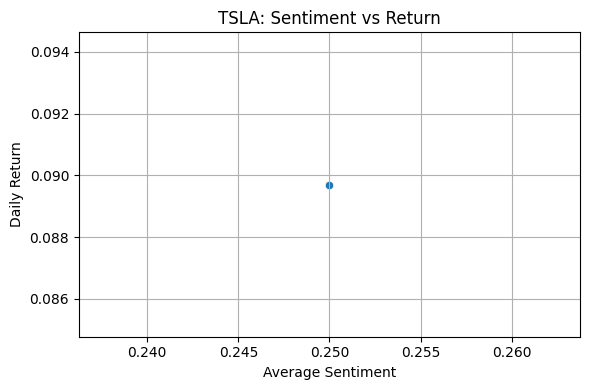

In [90]:


for stock in df_merged['stock'].unique():
    subset = df_merged[df_merged['stock'] == stock]
    
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=subset, x='avg_sentiment', y='return')
    plt.title(f'{stock}: Sentiment vs Return')
    plt.xlabel('Average Sentiment')
    plt.ylabel('Daily Return')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'../images/{stock}_sentiment_vs_return.png')
    plt.show()
